# Regresión Logística

Es un algoritmo de clasificación utilizado para modelar la probabilidad de que exista una cierta clase o evento.

Utiliza la función logística $f(x) = \dfrac{1}{1 + \mathrm{e}^{-x}}$ para regresar una probabilidad que se puede mapear en 2 o más clases discretas. Con esta función se ajusta a la variable y se obtiene un resultado en $[0,1]$.

Se utiliza cuando se quieren resultados binarios. Por ejemplo, decidir si un e-mail es spam o no, un tumor es maligno o benigno, si una inversión es buena o mala.


_Cheat sheet_ para la librería [seaborn](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Python_Seaborn_Cheat_Sheet.pdf)

In [1]:
# Se cargan las librerías que se van a utilizar
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn

%matplotlib inline

from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split


#from sklearn.preprocessing import scale 
#from sklearn.metrics import mean_squared_error
#from sklearn.metrics import r2_score

In [2]:
## 1) EXTRAER DATOS
# Los datos pueden encontrarse en diferentes formatos, en nuestro caso están en formato csv.

# Se carga la base de datos
df = pd.read_csv('titanic.csv') #Se encuentra en la misma carpeta que el jupyter notebook
print(df.shape) #Se tienen 1309 renglones y 12 columnas

(1309, 12)


In [3]:
## 2) ANÁLISIS EXPLORATORIO
# Se realiza una descripción analítica de los datos.
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,ParCh,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Los datos corresponden a la información de 1309 pasajeros del Titanic.

La información que se tiene de cada persona es (12 columnas):

   - **PassengerId:** Número de pasajero. $\{1, 2, 3, \ldots, 1309\}$
   - **Survived:** Variable binaria que vale 1 si el pasajero sobrevivió y 0 si no
   - **Pclass:** Clase en la que viajaba el pasajero
   - **Name:** Nombre del pasajero
   - **Sex:** Sexo del pasajer
   - **Age:** Edad del pasajero
   - **SibSp:** Número de hermanos/cónyuges abordo
   - **ParCh:** Número de padres/hijos abordo
   - **Ticket:** Clave del boleto
   - **Fare:** Tarifa pagada por el boleto (en unidades monetarias u.m.)
   - **Cabin:** Cabina en la que se quedó el pasajero durante el viaje
   - **Embarked:** Puerto en el que embarcó el pasajero. **C** = Cherbourg, **S** = Southampton, **Q** = Queenstown
   
Se desea predecir si los pasajeros sobreviven o no de acuerdo a sus características.

In [4]:
# Se cuenta el número de NaN's por columna
df.isnull().sum()

PassengerId       0
Survived          0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
ParCh             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

Al ver la tabla anterior tenemos:

   - 1014 NaN's en la columna 'Cabin'
   - 263 NaN's en la columna 'Age'
   - 2 NaN's en la columna 'Embarked'
   - 1 NaN's en la columna 'Fare'
   
Los datos de la cabina en la que se quedaron los pasajeros no influye en la predicción final. Es por ello que se va a eliminar esa columna de los datos que vamos a ulitizar.

Tampoco vamos a utilizar las columnas _PassengerId_, _Name_ ni _Ticket_.

Para la columna _Embarked_ vamos a sustituir los _NaN's_ por el puerto en el que más personas abordaron.

Para la columna _Fare_ vamos a sustituir los _NaN's_ por el promedio de las tarifas pagadas.

Para la columna _Age_ vamos a ver su comportamiento y decidir cómo sustituir los _NaN's_.

In [5]:
# Se eliminan las columnas 'Cabin', 'PassengerId', 'Ticket' y 'Name'.
df = pd.read_csv('titanic.csv').drop(['Cabin','PassengerId','Name','Ticket'], axis = 1)

print('Antes se tenían 1309 renglones y 12 columnas.\nAhora se tienen ',
      df.shape[0],' renglones y ',df.shape[1],' columnas.')
print('Se eliminaron ',1309-df.shape[0],' renglones y ',12-df.shape[1],' columnas.')
df.head()

Antes se tenían 1309 renglones y 12 columnas.
Ahora se tienen  1309  renglones y  8  columnas.
Se eliminaron  0  renglones y  4  columnas.


,Survived,Pclass,Sex,Age,SibSp,ParCh,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [6]:
# Se cambian los NaN's por el promedio de la columna 'Fare'
df["Fare"] = df["Fare"].fillna(df["Fare"].mean())
df.isnull().sum()#Verificamos que la columna "Fare" ya no tiene NaN's

Survived      0
Pclass        0
Sex           0
Age         263
SibSp         0
ParCh         0
Fare          0
Embarked      2
dtype: int64

Número de pasajeros que abordaron en cada puerto:
S    914
C    270
Q    123
Name: Embarked, dtype: int64
S = Southampton, C = Cherbourg, Q = Queenstown


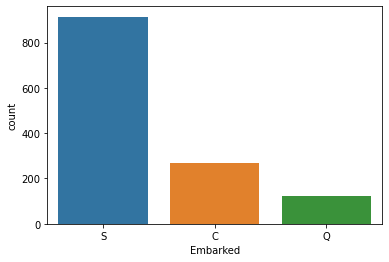

El puerto con mayor número de personas que abordaron el barco es Southampton


In [7]:
# Vamos a sustituir los NaN's de la columna 'Embarked' por el puerto en el que más personas abordaron.
# Hagamos el análisis respectivo:

print('Número de pasajeros que abordaron en cada puerto:')
print(df['Embarked'].value_counts())
print('S = Southampton, C = Cherbourg, Q = Queenstown')
sns.countplot(x='Embarked', data=df)
plt.show()


if df['Embarked'].value_counts().idxmax() == 'S':
    print('El puerto con mayor número de personas que abordaron el barco es Southampton')
elif df['Embarked'].value_counts().idxmax() == 'C':
    print('El puerto con mayor número de personas que abordaron el barco es Cherbourg')
else:
    print('El puerto con mayor número de personas que abordaron el barco es Queenstown')


In [8]:
# Se cambian los NaN's por el caracter 'S' correspondiente al puerto de Southampton
df["Embarked"] = df["Embarked"].fillna('S')
df.isnull().sum()#Verificamos que la columna "Embarked" ya no tiene NaN's

Survived      0
Pclass        0
Sex           0
Age         263
SibSp         0
ParCh         0
Fare          0
Embarked      0
dtype: int64

C:\Users\miri_\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Age', ylabel='Density'>

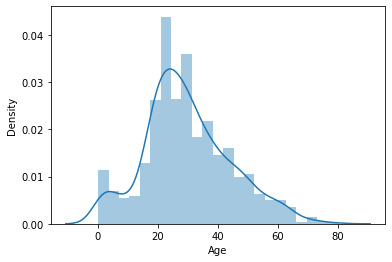

In [9]:
# Ahora hagamos el análisis correspondiente a la edad:
sns.distplot(df.Age)#Edad

In [10]:
df.Age.describe()

count    1046.000000
mean       29.881138
std        14.413493
min         0.170000
25%        21.000000
50%        28.000000
75%        39.000000
max        80.000000
Name: Age, dtype: float64

Con la gráfica y la tabla mostradas podemos decir que los datos no están centrados en su media (29.88).

Debido a esto vamos a elegir la mediana para sustituir los _NaN's_ de la columna _Age_.

In [11]:
# Se cambian los NaN's por la mediana de la columna 'Age'
df["Age"] = df["Age"].fillna(df["Age"].median(skipna=True))
df.isnull().sum()#Verificamos que la columna "Age" ya no tiene NaN's

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
ParCh       0
Fare        0
Embarked    0
dtype: int64

Vamos a eliminar las columnas _SibSp_ y _ParCh_.

Se van a cambiar por una columna llamada _CompAl (travel with company or alone)_.

Esta nueva columna va a tener un 1 en el _i-_ ésimo renglón si $SibSp_{i} + ParCh_{i} > 0$ y $0$ si no.

Nos va a indicar si un pasajero viajaba acompañado (1) o solo (0).

In [12]:
# Creamos la nueva columna con las características mencionadas
df['CompAl']=np.where((df["SibSp"]+df["ParCh"])>0, 1, 0)

print(df.head())

#Eliminamos las columnas 'SibSp' y 'ParCh'
df.drop('SibSp', axis=1, inplace=True)
df.drop('ParCh', axis=1, inplace=True)

df.head()

   Survived  Pclass     Sex   Age  SibSp  ParCh     Fare Embarked  CompAl
0         0       3    male  22.0      1      0   7.2500        S       1
1         1       1  female  38.0      1      0  71.2833        C       1
2         1       3  female  26.0      0      0   7.9250        S       0
3         1       1  female  35.0      1      0  53.1000        S       1
4         0       3    male  35.0      0      0   8.0500        S       0


,Survived,Pclass,Sex,Age,Fare,Embarked,CompAl
0,0,3,male,22.0,7.2500,S,1
1,1,1,female,38.0,71.2833,C,1
2,1,3,female,26.0,7.9250,S,0
3,1,1,female,35.0,53.1000,S,1
4,0,3,male,35.0,8.0500,S,0


In [13]:
# Se definen las varibles X (predictoras) y Y (dependiente)
Y = df["Survived"]
X = df.drop("Survived",axis=1)
print(type(X))
X.head()

<class 'pandas.core.frame.DataFrame'>


,Pclass,Sex,Age,Fare,Embarked,CompAl
0,3,male,22.0,7.2500,S,1
1,1,female,38.0,71.2833,C,1
2,3,female,26.0,7.9250,S,0
3,1,female,35.0,53.1000,S,1
4,3,male,35.0,8.0500,S,0


In [14]:
#Se definen las variables dummies para las variables categóricas 'Pclass', 'Sex' y 'Embarked'
clases = pd.get_dummies(df["Pclass"],drop_first=True)
print(clases.head())
dummies = pd.get_dummies(X[['Sex', 'Embarked']])
dummies.head()

   2  3
0  0  1
1  0  0
2  0  1
3  0  0
4  0  1


,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,1,0,0,1
1,1,0,1,0,0
2,1,0,0,0,1
3,1,0,0,0,1
4,0,1,0,0,1


In [15]:
#Se eliminan las columnas 'Pclass', 'Sex', 'Embarked' y se reemplazan por
#las variables dummies, una por la columna 'Sex' y 2 por las columnas 'Pclass' y 'Embarked'.
#Recordemos los valores de cada variable:
# 'Pclass': 1, 2, 3
# 'Sex': male, female
# 'Embarked': C, S, Q
print(X.head())
X = X.drop(['Pclass', 'Sex', 'Embarked'], axis = 1).astype('float64')
X = pd.concat([X,clases, dummies[['Sex_female', 'Embarked_C', 'Embarked_Q']]], axis = 1)

print(X.shape[0],' renglones\n',X.shape[1],' columnas')
X.head()

   Pclass     Sex   Age     Fare Embarked  CompAl
0       3    male  22.0   7.2500        S       1
1       1  female  38.0  71.2833        C       1
2       3  female  26.0   7.9250        S       0
3       1  female  35.0  53.1000        S       1
4       3    male  35.0   8.0500        S       0
1309  renglones
 8  columnas


,Age,Fare,CompAl,2,3,Sex_female,Embarked_C,Embarked_Q
0,22.0,7.2500,1.0,0,1,0,0,0
1,38.0,71.2833,1.0,0,0,1,1,0
2,26.0,7.9250,0.0,0,1,1,0,0
3,35.0,53.1000,1.0,0,0,1,0,0
4,35.0,8.0500,0.0,0,1,0,0,0


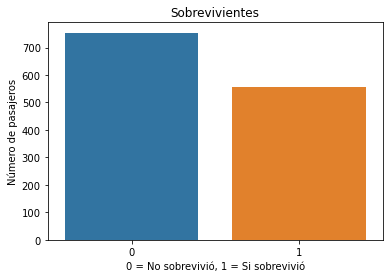

In [16]:
## 3) VISUALIZACIÓN DE LOS DATOS
# Para entender mejor los datos es necesario graficarlos.

# Gráfica de barras de los sobrevivientes
sns.countplot(x='Survived', data=df)
plt.title('Sobrevivientes')
plt.xlabel('0 = No sobrevivió, 1 = Si sobrevivió')
plt.ylabel('Número de pasajeros')
plt.show()

Vemos que el número de pasajeros que no sobrevió es mayor al número de sobrevivientes.

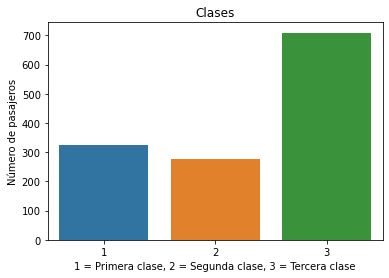

In [17]:
#Gráfica de barras de las clases de pasajeros
sns.countplot(x='Pclass', data=df)
plt.title('Clases')
plt.xlabel('1 = Primera clase, 2 = Segunda clase, 3 = Tercera clase')
plt.ylabel('Número de pasajeros')
plt.show()

El número de pasajeros de la tercera clase es mucho mayor al de las clases 1 y 2.

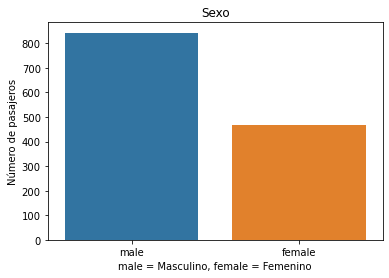

In [18]:
#Gráfica de barras de las clases de pasajeros
sns.countplot(x='Sex', data=df)
plt.title('Sexo')
plt.xlabel('male = Masculino, female = Femenino')
plt.ylabel('Número de pasajeros')
plt.show()

La mayor parte de los pasajeros eran hombres.

Edad mínima =  0.17
Edad máxima =  80.0


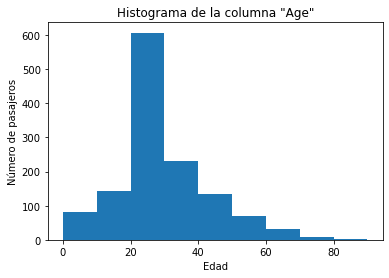

In [19]:
#Histograma de la columna 'Age'
print('Edad mínima = ',min(df.Age))
print('Edad máxima = ',max(df.Age))

plt.hist(df.Age, bins=[0,10,20,30,40,50,60,70,80,90]) #Se hace la división por cada 10 años
plt.title('Histograma de la columna "Age"')
plt.xlabel('Edad')
plt.ylabel('Número de pasajeros')
plt.show()

Se tienen alrededor de 600 pasajeros que tienen entre 20 y 30 años.

Es el grupo de edad con mayor número de pasajeros. El siguiente grupo es el de 30 a 40 años.

In [20]:
# Hacemos una tabla dividiendo las edades en diferentes categorías de acuerdo a la edad:
bins = [0, 5, 17, 30, 60, 80]
labels = ['Infantes', # 0 - 5 años
          'Niños', # 6 - 17 años
          'Jóvenes',# 18 - 30 años
          'Adultos',# 31 - 60 años
          'Ancianos']# 61 - 80 años
pd.cut(df['Age'], bins = bins, labels=labels).value_counts()

Jóvenes     718
Adultos     404
Niños        98
Infantes     56
Ancianos     33
Name: Age, dtype: int64

Con la tabla anterior podemos ver que el mayor número de pasajeros eran jóvenes entre 18 y 30 años.

Tarifa mínima =  0.0
Tarifa máxima =  512.3292


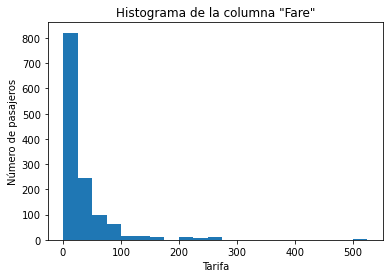

In [21]:
#Histograma de la columna 'Fare'
print('Tarifa mínima = ',min(df.Fare))
print('Tarifa máxima = ',max(df.Fare))

plt.hist(df.Fare, bins=[0,25,50,75,100,125,150,175,200,
                        225,250,275,300,325,350,375,400,
                        425,450,475,500,525]) #Se hace la división por cada 25 u.m.
plt.title('Histograma de la columna "Fare"')
plt.xlabel('Tarifa')
plt.ylabel('Número de pasajeros')
plt.show()

Más de 800 pasajeros pagaron menos de 25 u.m. por su boleto.

Estos datos confirman los resultados vistos en el análisis de las clases.

La mayoría de los pasajeros pagaron menos de 50 u.m.

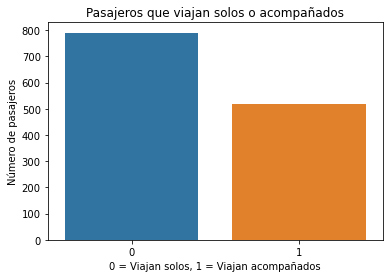

In [22]:
# Gráfica de barras de los pasajeros que viajan solos o acompañados
sns.countplot(x='CompAl', data=df)
plt.title('Pasajeros que viajan solos o acompañados')
plt.xlabel('0 = Viajan solos, 1 = Viajan acompañados')
plt.ylabel('Número de pasajeros')
plt.show()

Hay más pasajeros que viajan solos.

Observando todas las gráficas podemos concluir que la mayoría de los pasajeros eran hombres jóvenes que viajaban solos.

Podemos hacer gráficas con 2 características para poder obtener más información.

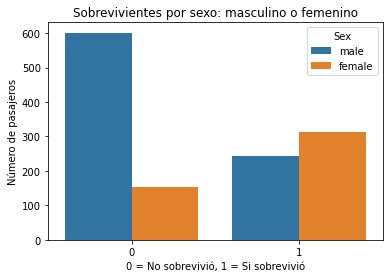

In [23]:
# Sobrevivientes por sexo
sns.countplot(x='Survived', hue='Sex', data=df)
plt.title('Sobrevivientes por sexo: masculino o femenino')
plt.xlabel('0 = No sobrevivió, 1 = Si sobrevivió')
plt.ylabel('Número de pasajeros')
plt.show()

Observamos que el número de hombres que no sobreviveron es un poco más del doble que el número de mujeres que no sobreviveron.

Esto se puede explicar debido a que dejaban subir primero a los botes salvavidas a mujeres y a niños.

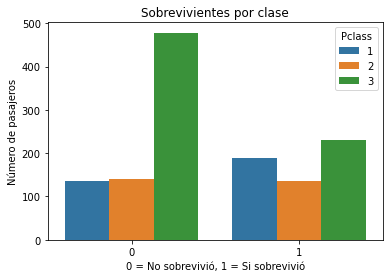

In [24]:
# Sobrevivientes con respecto a la clase
sns.countplot(x='Survived', hue='Pclass', data=df)
plt.title('Sobrevivientes por clase')
plt.xlabel('0 = No sobrevivió, 1 = Si sobrevivió')
plt.ylabel('Número de pasajeros')
plt.show()

Con esta gráfica vemos que el mayor número de pasajeros que no sobrevivió pertenecía a la clase más baja.

Viendo las 2 gráficas anteriores podemos concluir que la mayoría de los pasajeros que sobrevieron fueron mujeres de las clases 1 y 2.

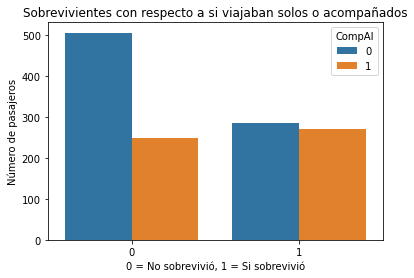

In [25]:
# Sobrevivientes con respecto a si viajaban solos o acompañados
sns.countplot(x='Survived', hue='CompAl', data=df)
plt.title('Sobrevivientes con respecto a si viajaban solos o acompañados')
plt.xlabel('0 = No sobrevivió, 1 = Si sobrevivió')
plt.ylabel('Número de pasajeros')
plt.show()

De las personas que sobrevivieron se tiene prácticamente el mismo número de pasajeros que viajaban solos que de pasajeros que viajaban acompañados.

De las personas que no sobrevivieron hay un mayor número de pasajeros que viajaban solos.

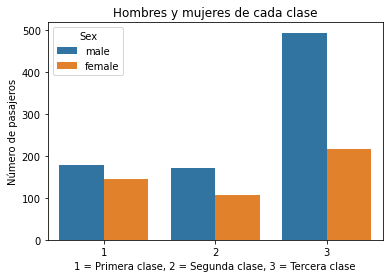

In [26]:
# Número de hombres y mujeres de cada clase
sns.countplot(x='Pclass', hue='Sex', data=df)
plt.title('Hombres y mujeres de cada clase')
plt.xlabel('1 = Primera clase, 2 = Segunda clase, 3 = Tercera clase')
plt.ylabel('Número de pasajeros')
plt.show()

En todas las clases hay más hombres que mujeres.

Particularmente en la tercera clase hay más hombres que en las clases 1 y 2.

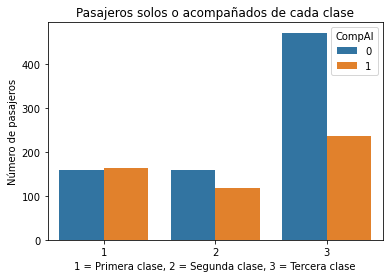

In [27]:
# Número pasajeros solos o acompañados de cada clase
sns.countplot(x='Pclass', hue='CompAl', data=df)
plt.title('Pasajeros solos o acompañados de cada clase')
plt.xlabel('1 = Primera clase, 2 = Segunda clase, 3 = Tercera clase')
plt.ylabel('Número de pasajeros')
plt.show()

En la primera clase el número de pasajeros que viajaban solos es casi el mismo que el de pasajeros que viajaban acompañados.

En la segunda clase el número de pasajeros que viajaban solos es un poco mayor que el de pasajeros que viajaban acompañados.

En la tercera clase el número de pasajeros que viajaban solos es mucho mayor que el de pasajeros que viajaban acompañados.


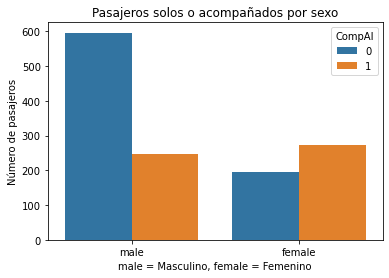

In [28]:
# Número pasajeros solos o acompañados por sexo
sns.countplot(x='Sex', hue='CompAl', data=df)
plt.title('Pasajeros solos o acompañados por sexo')
plt.xlabel('male = Masculino, female = Femenino')
plt.ylabel('Número de pasajeros')
plt.show()

Hay mucho más hombres que viajaban solos que mujeres que viajaban solas.

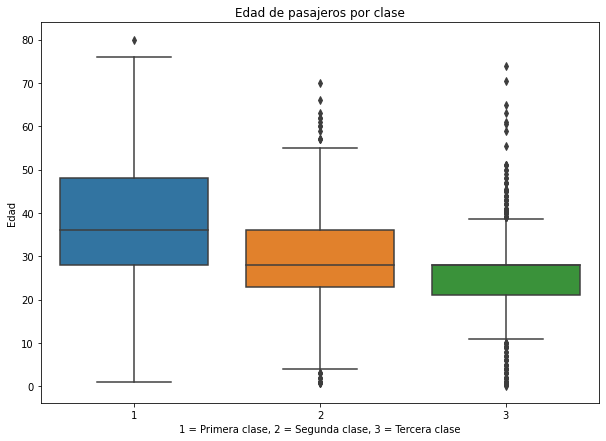

In [29]:
# Edad de pasajeros por clase
plt.figure(figsize=(10,7)) #Se ajusta el tamaño de la figura
sns.boxplot(x='Pclass',y='Age',data=df)
plt.title('Edad de pasajeros por clase')
plt.xlabel('1 = Primera clase, 2 = Segunda clase, 3 = Tercera clase')
plt.ylabel('Edad')
plt.show()

La clase con el mayor número de pasajeros entre 20 y 30 años es la tercera clase.

La edad de los pasajeros de la primera clase se encuentra entre 25 y 50 años (la mayor cantidad de personas).

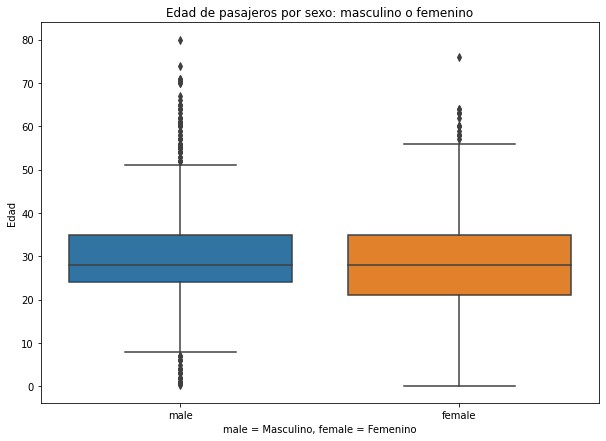

In [30]:
# Edad de pasajeros por sexo
plt.figure(figsize=(10,7)) #Se ajusta el tamaño de la figura
sns.boxplot(x='Sex',y='Age',data=df)
plt.title('Edad de pasajeros por sexo: masculino o femenino')
plt.xlabel('male = Masculino, female = Femenino')
plt.ylabel('Edad')
plt.show()

Con la gráfica anterior podemos ver que la edad de los pasajeros es similar sin importar si son hombres o mujeres.

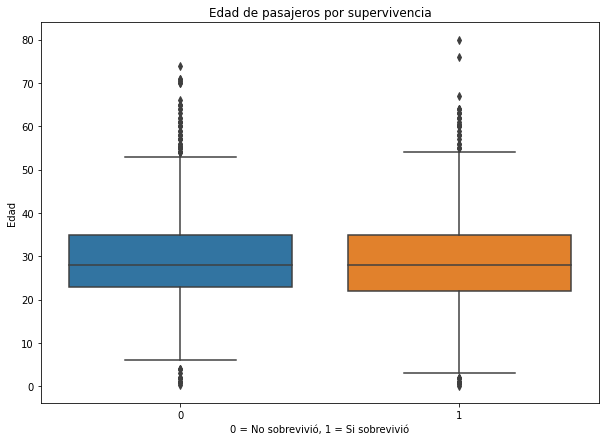

In [31]:
# Edad de pasajeros con respecto a la supervivencia
plt.figure(figsize=(10,7)) #Se ajusta el tamaño de la figura
sns.boxplot(x='Survived',y='Age',data=df)
plt.title('Edad de pasajeros por supervivencia')
plt.xlabel('0 = No sobrevivió, 1 = Si sobrevivió')
plt.ylabel('Edad')
plt.show()

En la gráfica anterior vemos que la edad de los pasajeros es similar sin importar si sobrevivieron o no.

In [32]:
## 4) DIVIDIR LOS DATOS
# Se separan los datos en 2 grupos:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size = 0.1,random_state = 44)

In [33]:
## 5) CONSTRUIR UN MODELO
# En este ejemplo vamos a elegir un modelo de regresión logística para "X_train"
logmodel = LogisticRegression()
logmodel.fit(X_train,Y_train)

LogisticRegression()

In [34]:
## 6) PREDICCIONES
# Se hacen las predicciones con "X_test"
Y_pred = logmodel.predict(X_test)

In [35]:
## 7) EVALUACIÓN DEL MODELO
print('Score = ',round(logmodel.score(X_train, Y_train) * 100, 2),
      '% = Tasa de respuestas correctas del modelo en el conjunto de entrenamiento')
print('Accuracy = ',round(metrics.accuracy_score(Y_test, Y_pred) * 100, 2),
      '% = Tasa de respuestas correctas del modelo en el conjunto de prueba')

Score =  70.2 % = Tasa de respuestas correctas del modelo en el conjunto de entrenamiento
Accuracy =  77.1 % = Tasa de respuestas correctas del modelo en el conjunto de prueba


(0.0, 90.0)

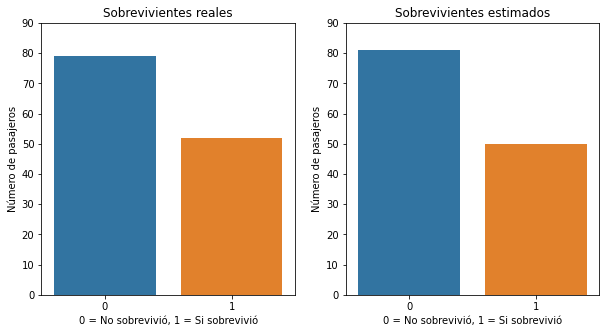

In [36]:
# Se grafican los resultados de la predicción junto con los valores reales
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)    
sns.countplot(x=Y_test, data=df)
plt.title('Sobrevivientes reales')
plt.xlabel('0 = No sobrevivió, 1 = Si sobrevivió')
plt.ylabel('Número de pasajeros')
plt.ylim(0,90)

plt.subplot(1,2,2)    
sns.countplot(x=Y_pred, data=df)
plt.title('Sobrevivientes estimados')
plt.xlabel('0 = No sobrevivió, 1 = Si sobrevivió')
plt.ylabel('Número de pasajeros')
plt.ylim(0,90)

In [37]:
# Matriz de confusión
mat_conf = confusion_matrix(Y_test, Y_pred)
print('Matriz de confusión:\n',mat_conf)

#Se definen las variables TP, TN, FP, FN
TP, TN, FP, FN = [mat_conf[0,0],mat_conf[1,1],mat_conf[0,1],mat_conf[1,0]]
print('\nTP = ',TP,'\nTN = ',TN,'\nFP = ',FP,'\nFN = ',FN)

#Se define la variable 'Total' = suma de los elementos de la matriz de confusión
Total = sum(sum(mat_conf))
print('Total = ',Total)

Matriz de confusión:
 [[65 14]
 [16 36]]

TP =  65 
TN =  36 
FP =  14 
FN =  16
Total =  131


In [38]:
print('Sensibilidad =', round(100*(TP/(TP+FN)), 2),'%')

Sensibilidad = 80.25 %


El porcentaje de los sobrevivientes predecidos correctamente es del 80.25%

In [39]:
print('Especificidad =', round(100*(TN/(TN+FP)), 2),'%')

Especificidad = 72.0 %


El porcentaje de los pasajeros que no sobrevivieron predecidos correctamente es del 72%

In [40]:
print('Tasa de falsos positivos =', round(100*(FP/(TN+FP)), 2),'%')

Tasa de falsos positivos = 28.0 %


El porcentaje de los sobrevivientes predecidos incorrectamente es del 28%

In [41]:
print('Precisión =', round(100*(TP /(TP+FP)), 2),'%')

Precisión = 82.28 %


El porcentaje de los sobrevivientes predecidos que son positivos es del 82.28%

In [42]:
print('T.R.I. =', round(100*((FN + FP)/Total), 2),'%')

T.R.I. = 22.9 %


La tasa de respuestas incorrectas es del 22%

In [43]:
print('Prevalencia =', round(100*((FN + TP)/Total), 2),'%')

Prevalencia = 61.83 %


El porcentaje de los sobrevientes reales es del 61.83%

# Conclusiones

La tasa de respuestas correctas del modelo en el conjunto de prueba es del 77.1 %.

El porcentaje de los sobrevivientes predecidos correctamente es del 80.25%.

El porcentaje de los pasajeros que no sobrevivieron predecidos correctamente es del 72%.

Con estos datos podemos decir que se predicen de mejor manera los casos de sobrevivientes que los casos de no supervivencia.

De acuerdo a las gráficas mostradas, 

   - La mayoría de los pasajeros que sobrevieron fueron mujeres de las clases 1 y 2.
   - El número de hombres que no sobreviveron es un poco más del doble que el número de mujeres que no sobreviveron.
   - La clase con el mayor número de pasajeros entre 20 y 30 años es la tercera clase.
   - La mayoría de los pasajeros eran hombres jóvenes que viajaban solos.